In [1]:
import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppresses INFO (1), WARNING (2), and ERROR (3)
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from tabulate import tabulate
from termcolor import colored as cl
from sklearn.metrics import precision_score, recall_score, f1_score


import tensorflow as tf
import flwr as fl
from flwr.common import Context
from imblearn.over_sampling import SMOTE
from flwr.common import parameters_to_ndarrays
from sdv.single_table import GaussianCopulaSynthesizer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
import ray
from scipy.interpolate import make_interp_spline, interp1d

E0000 00:00:1744988558.553551  652503 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744988558.557328  652503 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-18 10:02:40,373	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
/home/user/anaconda3/lib/python3.12/site-packages/rdt/transformers/utils.py:14: DeprecationWarning: module 'sre_parse' is deprecated
  import sre_parse  # isort:skip


In [3]:
NUM_CLIENTS = 10 # [5, 7, 9, 11, 13, 15]
# CLIENT_LIST = [5, 10, 15, 20, 25, 30]
LOCAL_EPOCHS = 1 # [3, 5, 7, 9, 11, 13]
NUM_ROUNDS = 10 # [5, 8, 11, 14, 17, 20]

In [ ]:
data = pd.read_csv('./data/EVSE_augmented_1.5.csv')

In [5]:
data.describe()

,time,alarmtimer_alarmtimer_cancel,alarmtimer_alarmtimer_fired,alarmtimer_alarmtimer_start,alarmtimer_alarmtimer_suspend,alignment-faults,ase_spec,block_block_bio_backmerge,block_block_bio_bounce,block_block_bio_complete,...,writeback_writeback_sb_inodes_requeue,writeback_writeback_single_inode,writeback_writeback_single_inode_start,writeback_writeback_start,writeback_writeback_wait,writeback_writeback_wait_iff_congested,writeback_writeback_wake_background,writeback_writeback_write_inode,writeback_writeback_write_inode_start,writeback_writeback_written
count,12702.000000,12702.0,12702.0,12702.0,12702.0,12702.0,1.270200e+04,12702.000000,12702.0,12702.0,...,12702.0,12702.0,12702.0,12702.0,12702.0,12702.0,12702.0,12702.0,12702.0,12702.0
mean,2164.277443,0.0,0.0,0.0,0.0,0.0,1.402211e+08,1124.503385,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,1825.508904,0.0,0.0,0.0,0.0,0.0,2.569261e+08,1784.317298,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,5.000000,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,318.892327,0.0,0.0,0.0,0.0,0.0,1.252915e+06,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,1815.323575,0.0,0.0,0.0,0.0,0.0,6.046535e+06,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,3687.752068,0.0,0.0,0.0,0.0,0.0,9.550802e+07,2326.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,5855.669471,0.0,0.0,0.0,0.0,0.0,9.738758e+08,5343.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
data.head()

,time,alarmtimer_alarmtimer_cancel,alarmtimer_alarmtimer_fired,alarmtimer_alarmtimer_start,alarmtimer_alarmtimer_suspend,alignment-faults,ase_spec,block_block_bio_backmerge,block_block_bio_bounce,block_block_bio_complete,...,writeback_writeback_wait_iff_congested,writeback_writeback_wake_background,writeback_writeback_write_inode,writeback_writeback_write_inode_start,writeback_writeback_written,ChargingState,Attack,Scenario,Label,interface
0,5.001477,0,0,0,0,0,693371795,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
1,5.001487,0,0,0,0,0,699964025,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
2,5.001641,0,0,0,0,0,549770341,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
3,5.003762,0,0,0,0,0,571970875,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
4,10.065740,0,0,0,0,0,553199786,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any


In [7]:
data["ChargingState"].value_counts()

ChargingState
Charging    7089
idle        5613
Name: count, dtype: int64

In [8]:
data["Label"].unique()

array(['attack', 'benign'], dtype=object)

In [9]:
cases = len(data)
benign_count = len(data[data.Label == "benign"])
attack_count = len(data[data.Label == "attack"])
anomolies_percentage = round(attack_count/cases*100, 2)

print(cl('CASE COUNT', attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))
print(cl('Total number of cases are {}'.format(cases), attrs = ['bold']))
print(cl('Number of Benign cases are {}'.format(benign_count), attrs = ['bold']))
print(cl('Number of attack cases are {}'.format(attack_count), attrs = ['bold']))
print(cl('Percentage of attack cases is {}'.format(anomolies_percentage), attrs = ['bold']))
print(cl('--------------------------------------------', attrs = ['bold']))

CASE COUNT
--------------------------------------------
Total number of cases are 12702
Number of Benign cases are 3454
Number of attack cases are 9248
Percentage of attack cases is 72.81
--------------------------------------------


In [10]:
data.duplicated().sum()

0

In [11]:
data = data.drop_duplicates()

In [12]:
total_rows = data.shape[0]
missing_columns = [col for col in data.columns if data[col].isnull().sum()>0]
for col in missing_columns:
  null_count = data[col].isnull().sum()
  per = (null_count/total_rows) * 100
  print(f"{col}: {null_count} ({round(per,3)}%)")

raw_syscalls_sys_enter: 2 (0.016%)
raw_syscalls_sys_exit: 3 (0.024%)
syscalls_sys_enter_arm64_personality: 5 (0.039%)
syscalls_sys_enter_capget: 4 (0.031%)
syscalls_sys_enter_capset: 2 (0.016%)
syscalls_sys_enter_clone: 3 (0.024%)
syscalls_sys_enter_clone3: 4 (0.031%)
syscalls_sys_enter_exit: 2 (0.016%)
syscalls_sys_enter_exit_group: 3 (0.024%)
syscalls_sys_enter_mmap: 2 (0.016%)
syscalls_sys_enter_rt_sigreturn: 3 (0.024%)
syscalls_sys_enter_set_tid_address: 3 (0.024%)
syscalls_sys_enter_unshare: 5 (0.039%)
syscalls_sys_enter_wait4: 2 (0.016%)
syscalls_sys_enter_waitid: 3 (0.024%)
syscalls_sys_exit_arm64_personality: 2 (0.016%)
syscalls_sys_exit_capget: 4 (0.031%)
syscalls_sys_exit_capset: 3 (0.024%)
syscalls_sys_exit_clone: 2 (0.016%)
syscalls_sys_exit_clone3: 3 (0.024%)
syscalls_sys_exit_exit: 3 (0.024%)
syscalls_sys_exit_exit_group: 2 (0.016%)
syscalls_sys_exit_mmap: 2 (0.016%)
syscalls_sys_exit_ptrace: 2 (0.016%)
syscalls_sys_exit_rt_sigreturn: 2 (0.016%)
syscalls_sys_exit_set_tid_

In [13]:
# Impute missing values using the mean for the specified columns
imputer = SimpleImputer(strategy='mean')

for col in missing_columns:
    data[col] = imputer.fit_transform(data[[col]])

data

,time,alarmtimer_alarmtimer_cancel,alarmtimer_alarmtimer_fired,alarmtimer_alarmtimer_start,alarmtimer_alarmtimer_suspend,alignment-faults,ase_spec,block_block_bio_backmerge,block_block_bio_bounce,block_block_bio_complete,...,writeback_writeback_wait_iff_congested,writeback_writeback_wake_background,writeback_writeback_write_inode,writeback_writeback_write_inode_start,writeback_writeback_written,ChargingState,Attack,Scenario,Label,interface
0,5.001477,0,0,0,0,0,693371795,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
1,5.001487,0,0,0,0,0,699964025,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
2,5.001641,0,0,0,0,0,549770341,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
3,5.003762,0,0,0,0,0,571970875,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
4,10.065740,0,0,0,0,0,553199786,0,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,attack,any
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12697,3606.096204,0,0,0,0,0,314710680,2793,0,0,...,0,0,0,0,0,Charging,cryptojacking,Benign,attack,any
12698,1676.161152,0,0,0,0,0,225297323,3612,0,0,...,0,0,0,0,0,idle,cryptojacking,Benign,attack,none
12699,44.944882,0,0,0,0,0,44789343,3726,0,0,...,0,0,0,0,0,Charging,port-scan,DoS,attack,ocpp
12700,2645.700642,0,0,0,0,0,167412921,4291,0,0,...,0,0,0,0,0,Charging,cryptojacking,Cryptojacking,benign,iso15118


In [14]:
def one_hot_encode(data):
    data = pd.get_dummies(data, columns=['ChargingState'], drop_first=True)
    return data

data = one_hot_encode(data)

def label_encode(data):
    for col in data.columns:
        if col == "Label":
            data["Label"] = data["Label"].map({'benign':0, 'attack':1})
        elif data[col].dtype == "object" and col != "ChargingState":
            data[col] = data[col].astype(str)
            label_encoder = LabelEncoder()
            data[col] = label_encoder.fit_transform(data[col])
    return data

data = label_encode(data)

data.head()

,time,alarmtimer_alarmtimer_cancel,alarmtimer_alarmtimer_fired,alarmtimer_alarmtimer_start,alarmtimer_alarmtimer_suspend,alignment-faults,ase_spec,block_block_bio_backmerge,block_block_bio_bounce,block_block_bio_complete,...,writeback_writeback_wait_iff_congested,writeback_writeback_wake_background,writeback_writeback_write_inode,writeback_writeback_write_inode_start,writeback_writeback_written,Attack,Scenario,Label,interface,ChargingState_idle
0,5.001477,0,0,0,0,0,693371795,0,0,0,...,0,0,0,0,0,2,1,1,0,False
1,5.001487,0,0,0,0,0,699964025,0,0,0,...,0,0,0,0,0,2,1,1,0,False
2,5.001641,0,0,0,0,0,549770341,0,0,0,...,0,0,0,0,0,2,1,1,0,False
3,5.003762,0,0,0,0,0,571970875,0,0,0,...,0,0,0,0,0,2,1,1,0,False
4,10.065740,0,0,0,0,0,553199786,0,0,0,...,0,0,0,0,0,2,1,1,0,False


In [15]:
# Select top 15 features using ANOVA F-score
X = data.drop(columns=["Label"])  
y = data["Label"]

In [16]:
scaler = StandardScaler()
# X_selected = scaler.fit_transform(data_selected)
X_selected = scaler.fit_transform(X)

# X_data = data.drop('Label', axis=1)
y_selected = data['Label']

In [17]:

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_selected, y_selected)


In [18]:
# Data Split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)


In [19]:
# Split data for each client
def split_data(X, y, num_clients):
    split_size = len(X) // num_clients
    return [(X[i*split_size:(i+1)*split_size], y[i*split_size:(i+1)*split_size]) for i in range(num_clients)]

client_datasets = split_data(X_train, y_train, NUM_CLIENTS)


In [20]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model



In [21]:
class FLClient(fl.client.NumPyClient):
    def __init__(self, model, train_data, cid, local_epochs):
        self.model = model
        self.train_data = train_data
        self.cid = cid
        self.local_epochs = local_epochs
   
    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        X, y = self.train_data
        self.model.fit(X, y, epochs=self.local_epochs, batch_size=32, verbose=0)
        return self.model.get_weights(), len(X), {}

    def evaluate(self, parameters, config):
        self.model.set_weights(parameters)
        X, y = self.train_data
        loss, accuracy = self.model.evaluate(X, y, verbose=0)
    
        # Predictions and classification
        y_pred_probs = self.model.predict(X, verbose=0)
        y_pred = (y_pred_probs > 0.5).astype("int32")
    
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
    
        print(f"[Client {self.cid} Eval] Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
        # Logging
        with open(f"output/FedAvg/client_{self.cid}_clients_{NUM_CLIENTS}.epochs_{self.local_epochs}_accuracy_FedAvg.log", "a") as f:
            f.write(f"{accuracy}\n")
        with open(f"output/FedAvg/client_{self.cid}_clients_{NUM_CLIENTS}.epochs_{self.local_epochs}_loss_FedAvg.log", "a") as f:
            f.write(f"{loss}\n")
    
        return loss, len(X), {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1
        }

In [22]:
def client_fn(cid: str):
    cid_int = int(cid)
    model = create_model()
    return FLClient(model, client_datasets[cid_int], cid, local_epochs = LOCAL_EPOCHS)

In [23]:

def weighted_average(metrics):
    total_examples = sum(num_examples for num_examples, _ in metrics)

    # Initialize accumulators for each metric
    aggregated = {
        "accuracy": 0.0,
        "precision": 0.0,
        "recall": 0.0,
        "f1_score": 0.0
    }

    for num_examples, m in metrics:
        for key in aggregated:
            aggregated[key] += m[key] * num_examples

    # Final weighted average
    for key in aggregated:
        aggregated[key] /= total_examples

    return aggregated


In [24]:
# Custom aggregrate class
class ModelAggregrate(fl.server.strategy.FedAvg):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.final_weights = None

    def aggregate_fit(self, server_round, results, failures):
        aggregated_weights, _ = super().aggregate_fit(server_round, results, failures)
        if aggregated_weights is not None:
            self.final_weights = aggregated_weights  # Save for later use
        return aggregated_weights, {}

# Use the custom strategy
strategy = ModelAggregrate(
    fraction_fit=1.0,
    min_fit_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    evaluate_metrics_aggregation_fn=weighted_average,
)

In [25]:
def reset_logfile():
    for cid in range(NUM_CLIENTS):
        log_file_accuracy = f"output/FedAvg/client_{cid}_clients_{NUM_CLIENTS}.epochs_{LOCAL_EPOCHS}_accuracy_FedAvg.log"
        log_file_loss = f"output/FedAvg/client_{cid}_clients_{NUM_CLIENTS}.epochs_{LOCAL_EPOCHS}_loss_FedAvg.log"
        if os.path.exists(log_file_accuracy):
            os.remove(log_file_accuracy)
        if os.path.exists(log_file_loss):
            os.remove(log_file_loss)
            
reset_logfile()
ray.shutdown()

In [26]:
history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=NUM_ROUNDS),
    ray_init_args={"num_cpus": 6},  # Limits overall Ray CPU allocation
    client_resources={"num_cpus": 1},  # Ensures controlled task scheduling
    strategy=strategy,
)
ray.shutdown()

	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2025-04-18 10:02:56,344	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 6.0, 'object_store_memory': 6703260057.0, 'node:10.0.5.98': 1.0, 'memory': 13406520116.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 6 acto

(ClientAppActor pid=676093) [Client 9 Eval] Accuracy: 0.8871, Precision: 0.9283, Recall: 0.8431, F1: 0.8836


(ClientAppActor pid=676093) 
(ClientAppActor pid=676093)         
(ClientAppActor pid=676097) 
(ClientAppActor pid=676097)         
(ClientAppActor pid=676096) 
(ClientAppActor pid=676096)         
(ClientAppActor pid=676095) 
(ClientAppActor pid=676095)         
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=676096) 
(ClientAppActor pid=676096)         
(ClientAppActor pid=676095) 
(ClientAppActor pid=676095)         
(ClientAppActor pid=676093) 
(ClientAppActor pid=676093)         
(ClientAppActor pid=676097) 
(ClientAppActor pid=676097)         
(ClientAppActor pid=676098) 
(ClientAppActor pid=676098)         
(ClientAppActor pid=676094) 
(ClientAppActor pid=676094)         
(ClientAppActor pid=676096) 
(ClientAppActor pid=676096)         
(ClientAppActor pid=676096) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def clie

(ClientAppActor pid=676095) [Client 3 Eval] Accuracy: 0.9040, Precision: 0.9121, Recall: 0.8949, F1: 0.9034 [repeated 20x across cluster]


(ClientAppActor pid=676096) 
(ClientAppActor pid=676096)         
(ClientAppActor pid=676095) 
(ClientAppActor pid=676095)         
(ClientAppActor pid=676093) 
(ClientAppActor pid=676093)         
(ClientAppActor pid=676097) 
(ClientAppActor pid=676097)         
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=676093) 
(ClientAppActor pid=676093)         
(ClientAppActor pid=676097) 
(ClientAppActor pid=676097)         
(ClientAppActor pid=676096) 
(ClientAppActor pid=676096)         
(ClientAppActor pid=676096) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 7x across cluster]
(ClientAppActor pid=676096)             This is a deprecated fe

(ClientAppActor pid=676097) [Client 9 Eval] Accuracy: 0.9297, Precision: 0.9488, Recall: 0.9109, F1: 0.9294 [repeated 10x across cluster]


(ClientAppActor pid=676098) 
(ClientAppActor pid=676098)         
(ClientAppActor pid=676097) 
(ClientAppActor pid=676097)         
(ClientAppActor pid=676094) 
(ClientAppActor pid=676094)         
(ClientAppActor pid=676095) 
(ClientAppActor pid=676095)         
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=676093) 
(ClientAppActor pid=676093)         
(ClientAppActor pid=676098) 
(ClientAppActor pid=676098)         
(ClientAppActor pid=676094) 
(ClientAppActor pid=676094)         
(ClientAppActor pid=676097) 
(ClientAppActor pid=676097)         
(ClientAppActor pid=676095) 
(ClientAppActor pid=676095)         
(ClientAppActor pid=676096) 
(ClientAppActor pid=676096)         
(ClientAppActor pid=676095) 
(ClientAppActor pid=676095)         
(ClientAppActor pid=676095) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def clie

(ClientAppActor pid=676095) [Client 5 Eval] Accuracy: 0.9283, Precision: 0.9385, Recall: 0.9184, F1: 0.9284 [repeated 13x across cluster]


(ClientAppActor pid=676096) 
(ClientAppActor pid=676096)         
(ClientAppActor pid=676096) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 8x across cluster]
(ClientAppActor pid=676096)             This is a deprecated feature. It will be removed [repeated 8x across cluster]
(ClientAppActor pid=676096)             entirely in future versions of Flower. [repeated 8x across cluster]
(ClientAppActor pid=676095) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 8x across cluster]
(ClientAppActor pid=676094) 
(ClientAppActor pid=676094)         
(ClientAppActor pid=676093) 
(ClientAppActor pid=676093)         


(ClientAppActor pid=676097) [Client 9 Eval] Accuracy: 0.9351, Precision: 0.9530, Recall: 0.9176, F1: 0.9350 [repeated 7x across cluster]


(ClientAppActor pid=676093) 
(ClientAppActor pid=676093)         
(ClientAppActor pid=676098) 
(ClientAppActor pid=676098)         
(ClientAppActor pid=676097) 
(ClientAppActor pid=676097)         
(ClientAppActor pid=676095) 
(ClientAppActor pid=676095)         
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=676098) 
(ClientAppActor pid=676098)         
(ClientAppActor pid=676097) 
(ClientAppActor pid=676097)         
(ClientAppActor pid=676095) 
(ClientAppActor pid=676095)         
(ClientAppActor pid=676093) 
(ClientAppActor pid=676093)         
(ClientAppActor pid=676094) 
(ClientAppActor pid=676094)         
(ClientAppActor pid=676096) 
(ClientAppActor pid=676096)         
(ClientAppActor pid=676096) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {

(ClientAppActor pid=676094) [Client 2 Eval] Accuracy: 0.9263, Precision: 0.9617, Recall: 0.8921, F1: 0.9256 [repeated 10x across cluster]


(ClientAppActor pid=676098) 
(ClientAppActor pid=676098)         
(ClientAppActor pid=676094) 
(ClientAppActor pid=676094)         
(ClientAppActor pid=676097) 
(ClientAppActor pid=676097)         
(ClientAppActor pid=676095) 
(ClientAppActor pid=676095)         
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=676098) 
(ClientAppActor pid=676098)         
(ClientAppActor pid=676097) 
(ClientAppActor pid=676097)         
(ClientAppActor pid=676095) 
(ClientAppActor pid=676095)         
(ClientAppActor pid=676093) 
(ClientAppActor pid=676093)         
(ClientAppActor pid=676096) 
(ClientAppActor pid=676096)         
(ClientAppActor pid=676094) 
(ClientAppActor pid=676094)         
(ClientAppActor pid=676098) 
(ClientAppActor pid=676098)         
(ClientAppActor pid=676097) 
(ClientAppActor pid=676097)         
(ClientAppActor pid=676095) 
(ClientApp

(ClientAppActor pid=676097) [Client 4 Eval] Accuracy: 0.9398, Precision: 0.9542, Recall: 0.9247, F1: 0.9392 [repeated 17x across cluster]


(ClientAppActor pid=676098) 
(ClientAppActor pid=676098)         
(ClientAppActor pid=676095) 
(ClientAppActor pid=676095)         
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=676095) 
(ClientAppActor pid=676095)         
(ClientAppActor pid=676093) 
(ClientAppActor pid=676093)         
(ClientAppActor pid=676096) 
(ClientAppActor pid=676096)         
(ClientAppActor pid=676098) 
(ClientAppActor pid=676098)         
(ClientAppActor pid=676094) 
(ClientAppActor pid=676094)         
(ClientAppActor pid=676097) 
(ClientAppActor pid=676097)         
(ClientAppActor pid=676095) 
(ClientAppActor pid=676095)         
(ClientAppActor pid=676093) 
(ClientAppActor pid=676093)         
(ClientAppActor pid=676098) 
(ClientAppActor pid=676098)         
(ClientAppActor pid=676097) 
(ClientAppActor pid=676097)         
INFO :      aggregate_fit: received 10 

(ClientAppActor pid=676097) [Client 0 Eval] Accuracy: 0.9297, Precision: 0.9636, Recall: 0.8883, F1: 0.9244 [repeated 3x across cluster]


(ClientAppActor pid=676093) 
(ClientAppActor pid=676093)         
(ClientAppActor pid=676098) 
(ClientAppActor pid=676098)         
(ClientAppActor pid=676097) 
(ClientAppActor pid=676097)         
(ClientAppActor pid=676095) 
(ClientAppActor pid=676095)         
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)
(ClientAppActor pid=676093) 
(ClientAppActor pid=676093)         
(ClientAppActor pid=676096) 
(ClientAppActor pid=676096)         
(ClientAppActor pid=676098) 
(ClientAppActor pid=676098)         
(ClientAppActor pid=676094) 
(ClientAppActor pid=676094)         
(ClientAppActor pid=676097) 
(ClientAppActor pid=676097)         
(ClientAppActor pid=676095) 
(ClientAppActor pid=676095)         
(ClientAppActor pid=676093) 
(ClientAppActor pid=676093)         
(ClientAppActor pid=676097) 
(ClientAppActor pid=676097)         
(ClientAppActor pid=676095) 
(ClientAp

(ClientAppActor pid=676097) [Client 2 Eval] Accuracy: 0.9371, Precision: 0.9638, Recall: 0.9118, F1: 0.9371 [repeated 10x across cluster]


(ClientAppActor pid=676093) 
(ClientAppActor pid=676093)         
(ClientAppActor pid=676096) 
(ClientAppActor pid=676096)         
(ClientAppActor pid=676094) 
(ClientAppActor pid=676094)         
(ClientAppActor pid=676097) 
(ClientAppActor pid=676097)         
INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 57.97s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.427132585644722
INFO :      		round 2: 0.2852118700742722
INFO :      		round 3: 0.21244158893823623
INFO :      		round 4: 0.1826360359787941
INFO :      		round 5: 0.16709052473306657
INFO :      		round 6: 0.15905843377113343
INFO :      		round 7: 0.15411545485258102
INFO :      		round 8: 0.14859419763088227
INFO :      		round 9: 0.1434410661458969
INFO :      		round 10: 0.14050836712121964
INFO :      	History (metrics, distributed, evaluate):
INFO :      	{'accuracy': [(1, 0.8780933082103729),
INFO :      

(ClientAppActor pid=676096) [Client 1 Eval] Accuracy: 0.9405, Precision: 0.9642, Recall: 0.9187, F1: 0.9409 [repeated 5x across cluster]


In [61]:
# Model Save
final_model = create_model()
final_weight = parameters_to_ndarrays(strategy.final_weights)
final_model.set_weights(final_weight)
final_model.save("global_model_FedAvg.h5")
print("Global model saved as 'global_model_FedAvg.h5' ✅")

Global model saved as 'global_model_FedAvg.h5' ✅


In [27]:

# Start with an empty DataFrame
metrics_df = pd.DataFrame()

# Go through each metric
for metric_name, round_values in history.metrics_distributed.items():
    # Convert list of (round, value) into DataFrame
    df = pd.DataFrame(round_values, columns=["round", metric_name])
    df.set_index("round", inplace=True)

    # Merge with main table
    metrics_df = pd.concat([metrics_df, df], axis=1)

# Optional: sort by round and round decimals
metrics_df = metrics_df.sort_index().round(4)

# Extract global loss values
global_loss = [loss for _, loss in history.losses_distributed]

# Add global_loss as the last column
metrics_df["loss"] = global_loss

# Reorder columns to ensure 'loss' is at the end
cols = [col for col in metrics_df.columns if col != "loss"] + ["loss"]
metrics_df = metrics_df[cols]

# Display the final DataFrame
metrics_df


,accuracy,precision,recall,f1_score,loss
round,,,,,
1,0.8781,0.9136,0.8354,0.8727,0.427133
2,0.9094,0.9182,0.8988,0.9084,0.285212
3,0.9193,0.9294,0.9075,0.9183,0.212442
4,0.9247,0.9418,0.9055,0.9232,0.182636
5,0.9289,0.9451,0.9107,0.9276,0.167091
6,0.9316,0.9506,0.9105,0.9301,0.159058
7,0.9320,0.9587,0.9031,0.9300,0.154115
8,0.9356,0.9579,0.9112,0.9339,0.148594
9,0.9371,0.9608,0.9114,0.9354,0.143441


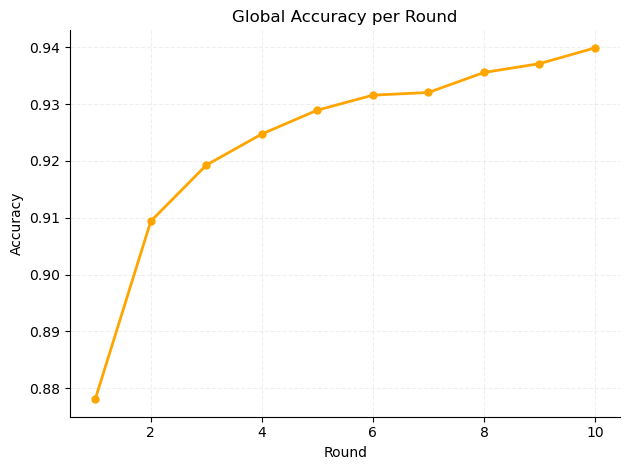

In [28]:
rounds = list(range(1, len(history.metrics_distributed["accuracy"]) + 1))
accuracies = [acc for _, acc in history.metrics_distributed["accuracy"]]

rounds_np = np.array(rounds)
accuracies_np = np.array(accuracies)

# Use linear interpolation instead of cubic spline
interpolator = interp1d(rounds_np, accuracies_np, kind='linear')
rounds_smooth = np.linspace(rounds_np.min(), rounds_np.max(), 100)
accuracies_smooth = interpolator(rounds_smooth)

fig, ax = plt.subplots(facecolor='white')  
ax.plot(rounds_smooth, accuracies_smooth, color='orange', linewidth=2)
ax.plot(rounds_np, accuracies_np, marker='.', linestyle='None', color='orange', markersize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Labels and grid
ax.set_title("Global Accuracy per Round")
ax.set_xlabel("Round")
ax.set_ylabel("Accuracy")
ax.grid(True, linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()


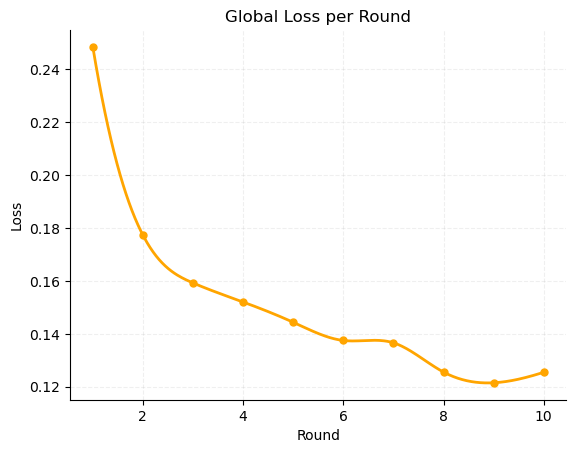

In [91]:
global_loss = [loss for _, loss in history.losses_distributed]
rounds = list(range(1,len(global_loss)+1))

rounds_np = np.array(rounds)
losses_np = np.array(global_loss)

rounds_smooth = np.linspace(rounds_np.min(), rounds_np.max(), 300)
spline = make_interp_spline(rounds_np, losses_np, k=3)
losses_smooth = spline(rounds_smooth)

fig, ax = plt.subplots(facecolor='white')  # White figure background
# ax.set_facecolor('white')  # White plot background
ax.plot(rounds_smooth, losses_smooth, color='orange', linewidth=2)
ax.plot(rounds_np, losses_np, marker='.', linestyle='None', color='orange', markersize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title("Global Loss per Round")
plt.xlabel("Round")
plt.ylabel("Loss")
ax.grid(True, linestyle='--', alpha=0.2)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))

for cid in range(NUM_CLIENTS):
    log_file = f"output/FedAvg/client_{cid}_clients_{NUM_CLIENTS}.epochs_{LOCAL_EPOCHS}_accuracy_FedAvg.log"
    if os.path.exists(log_file):
        with open(log_file, "r") as f:
            accuracies = [float(line.strip()) for line in f.readlines()]
            plt.plot(range(1, len(accuracies)+1), accuracies, marker='o', label=f"Client {cid + 1}")

plt.title("Client Accuracy per Round")
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()